# Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# Dataset

In [2]:
from google.colab import files

uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [3]:
!pip install kaggle

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d karanchinchpure/house-price-predict-in-mumbai-city

  0% 0.00/48.9k [00:00<?, ?B/s]
100% 48.9k/48.9k [00:00<00:00, 63.1MB/s]


In [6]:
!unzip house-price-predict-in-mumbai-city.zip

Archive:  house-price-predict-in-mumbai-city.zip
  inflating: house_price_mumbai.csv  


# Standardising Data

In [383]:
filename = '/content/house_price_mumbai.csv'
data = pd.read_csv(filename)

In [384]:
print(f" \t House attributes = {data.columns.values}, \n \t No. of house records = {data.shape[0]}, \n \t Shape of Data = {data.shape}")

 	 House attributes = ['BHK' 'project' 'Location' 'City' 'Total sqft' 'price_sqft' 'price'], 
 	 No. of house records = 3980, 
 	 Shape of Data = (3980, 7)


### Dropping redundunt columns (project, Location, City)

In [385]:
drop_attributes = ['project', 'Location', 'City']
data.drop(drop_attributes, axis = 1, inplace = True)

In [386]:
def minMaxNormalization(value, max_value, min_value):
  return (value - min_value) / (max_value - min_value)

### Converting price to Integer values

In [387]:
def updatePrice(price):
  price_sep = price.split(' ')
  denomination = price_sep[1]
  price_value = float(price_sep[0])

  if (denomination == 'Cr'):
    price_value = price_value * 1_00_00_000
  elif (denomination == 'L'):
    price_value = price_value * 1_00_000

  return price_value

In [388]:
attribute_name = 'price'
data[attribute_name] = data[attribute_name].apply(lambda value : updatePrice(value))

### Converting priceSqft to integer values

In [389]:
def updatePriceSqft(priceSqft):
  return int(priceSqft.replace(',', ''))

In [390]:
attribute_name = 'price_sqft'
data[attribute_name] = data[attribute_name].apply(lambda value : updatePriceSqft(value))

### Converting BHK to numbers

In [391]:
def updateBHKInfo(bhk):
  if (bhk.split(' ')[0] == 'R'):
    return 1
  return int(bhk.split(' ')[0])

In [392]:
attribute_name = 'BHK'
data[attribute_name] = data[attribute_name].apply(lambda value : updateBHKInfo(value))

In [393]:
from copy import deepcopy
data_deNormalized = deepcopy(data)

In [394]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3980 entries, 0 to 3979
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   BHK         3980 non-null   int64  
 1   Total sqft  3980 non-null   int64  
 2   price_sqft  3980 non-null   int64  
 3   price       3980 non-null   float64
dtypes: float64(1), int64(3)
memory usage: 124.5 KB


### Normalization of values

In [396]:
min_priceSqft, max_priceSqft, min_totalSqft, max_totalSqft, min_price, max_price = 0, 0, 0, 0, 0, 0

In [397]:
attribute_name = 'price_sqft'
min_priceSqft, max_priceSqft = data[attribute_name].min(), data[attribute_name].max()
data[attribute_name] = data[attribute_name].apply(lambda value : minMaxNormalization(value, max_priceSqft, min_priceSqft))

In [398]:
attribute_name = 'Total sqft'
min_totalSqft, max_totalSqft = data[attribute_name].min(), data[attribute_name].max()
data[attribute_name] = data[attribute_name].apply(lambda value : minMaxNormalization(value, max_totalSqft, min_totalSqft))

In [399]:
attribute_name = 'price'
min_price, max_price = data[attribute_name].min(), data[attribute_name].max()
data[attribute_name] = data[attribute_name].apply(lambda value : minMaxNormalization(value, max_price, min_price))

# Visual Representation for 2, 3, 4 BHK Houses

In [400]:
attribute_name, x_axis, y_axis = 'BHK', 'Total sqft', 'price'

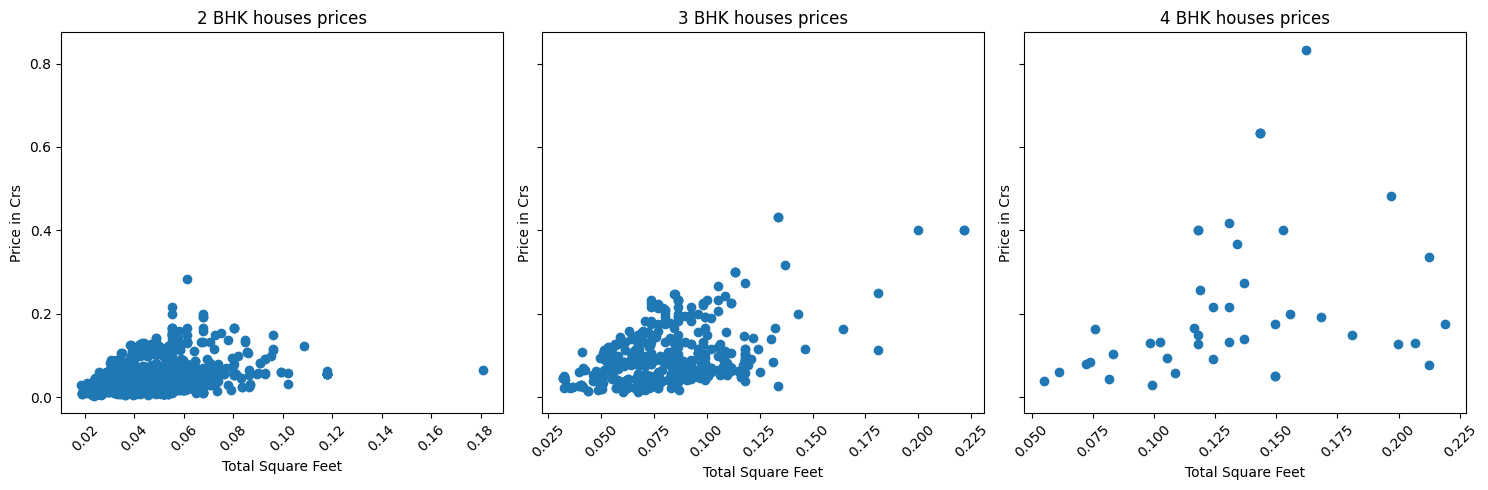

In [401]:
attribute_name, x_axis, y_axis = 'BHK', 'Total sqft', 'price'

bhk_uniques = data[attribute_name].unique()
bhk_uniques.sort()
bhk_uniques = bhk_uniques[1:4]

fig, axes = plt.subplots(nrows=1, ncols=len(bhk_uniques), figsize=(15, 5), sharey=True)

for i, u_bhk in enumerate(bhk_uniques):
    indexes = data[data[attribute_name] == u_bhk].index
    axes[i].scatter(data[data.index.isin(indexes)][x_axis], data[data.index.isin(indexes)][y_axis])
    axes[i].set_title(f"{u_bhk} BHK houses prices")
    axes[i].set_xlabel("Total Square Feet")
    axes[i].set_ylabel("Price in Crs")

    axes[i].tick_params(axis = 'x', rotation = 45)

plt.tight_layout()
plt.show()

# Train Test split data

In [402]:
x_attributes, y_attributes = ['BHK', 'Total sqft', 'price_sqft'], ['price']
x_train, x_test, y_train, y_test = train_test_split(data[x_attributes], data[y_attributes], test_size = 0.03, random_state = 1234)

print(f"Data stats: \n Training data size [ x = {x_train.shape}, y = {y_train.shape} ] \n Testing data size [ x = {x_test.shape}, y  = {y_test.shape} ] \n")

Data stats: 
 Training data size [ x = (3860, 3), y = (3860, 1) ] 
 Testing data size [ x = (120, 3), y  = (120, 1) ] 



In [403]:
x_train_np, y_train_np = np.array(x_train), np.array(y_train)

# Simple Linear Regression

In [404]:
def compute_cost(x, y, W, B):

  records = x.shape[0]
  cost = 0

  for i in range(records):
    f_wb_i = np.dot(W, x[i]) + B
    cost = cost + (f_wb_i - y[i])**2
  total_cost = 1 / (2 * records) * cost
  return total_cost

In [405]:
def compute_gradient(x, y, W, B):

  records = x.shape[0]
  dj_dW, dj_dB = 0, 0

  for i in range(records):
    f_wb_i = np.dot(W, x[i]) + B
    dj_dW = dj_dW + (f_wb_i - y[i]) * x[i]
    dj_dB = dj_dB + (f_wb_i - y[i])

  dj_dW, dj_dB = (dj_dW / records), (dj_dB / records)
  return dj_dW, dj_dB

In [406]:
def gradient_descent(x, y, W, B, epochs = 10, learning_rate = 0.01):

  J_cost = []
  for i in range(epochs):

    dj_dW, dj_dB = compute_gradient(x, y, W, B)

    W = W - learning_rate * dj_dW
    B = B - learning_rate * dj_dB

    J_cost.append(compute_cost(x, y, W, B))
  return W, B, J_cost

In [446]:
# W = np.random.randint(low = 0, high = 10, size = (3, ))
# W = np.zeros((3, ))
W = np.random.randn(3)
B = 0
epochs = 1000
learning_rate = 0.05

print(f"Initial values of W = {W}, and B = {B}");

W, B, J_cost = gradient_descent(x_train_np, y_train_np, W, B, epochs = epochs, learning_rate = learning_rate)
print(f"Trained values of W = {W} and B = {B}")

Initial values of W = [ 0.10517522 -0.31088808 -0.0277613 ], and B = 0
Trained values of W = [ 0.01708537 -0.24335255  0.14932198] and B = [-0.00148736]


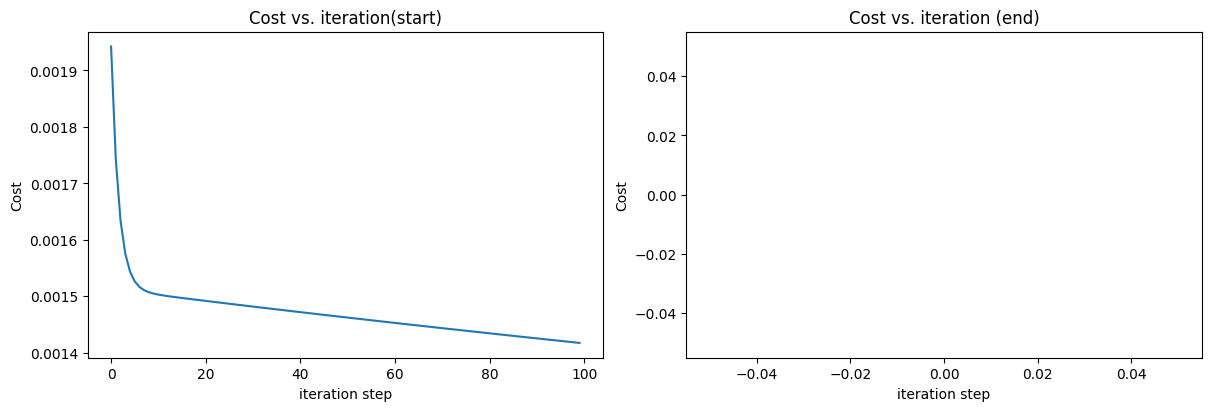

In [439]:
# plot cost versus iteration
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(12,4))
ax1.plot(J_cost[:100])
ax2.plot(1000 + np.arange(len(J_cost[1000:])), J_cost[1000:])
ax1.set_title("Cost vs. iteration(start)");  ax2.set_title("Cost vs. iteration (end)")
ax1.set_ylabel('Cost')            ;  ax2.set_ylabel('Cost')
ax1.set_xlabel('iteration step')  ;  ax2.set_xlabel('iteration step')
plt.show()

In [440]:
def predict(x, W, B):

  records = x.shape[0]
  y_pred_list = []
  for i in range(records):

    y_pred = np.dot(W, x[i]) + B
    y_pred_list.append(y_pred)

  return y_pred_list

In [441]:
# x_test_np, y_test_np = np.array(x_test), np.array(y_test)
x_test_np, y_test_np = np.array(x_train), np.array(y_train)
y_predictions = predict(x_test_np, W, B)

In [442]:
def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

In [443]:
mse = mean_squared_error(y_test_np, y_predictions)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.002834986498881663


### Converting y_predictions for normal values

In [444]:
# y_predictions = np.array(y_predictions)
# y_predictions = y_predictions * (max_price - min_price) + min_price

In [435]:
y_predictions = pd.DataFrame(y_predictions, columns=['price'])

In [436]:
x_train.shape, y_train.shape, y_predictions.shape

((3860, 3), (3860, 1), (3860, 1))

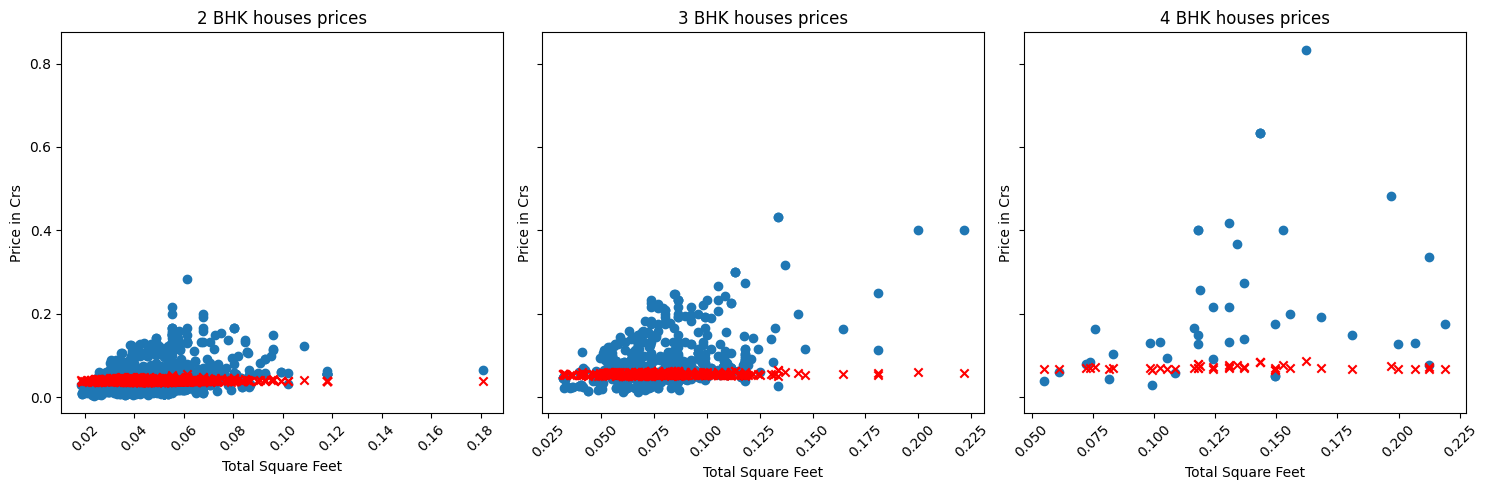

In [437]:
attribute_name, x_axis, y_axis = 'BHK', 'Total sqft', 'price'

bhk_uniques = x_train[attribute_name].unique()
bhk_uniques.sort()
bhk_uniques = bhk_uniques[1:4]

fig, axes = plt.subplots(nrows=1, ncols=len(bhk_uniques), figsize=(15, 5), sharey=True)

for i, u_bhk in enumerate(bhk_uniques):
    indexes = x_train[x_train[attribute_name] == u_bhk].index
    axes[i].scatter(x_train[x_train.index.isin(indexes)][x_axis], y_train[x_train.index.isin(indexes)][y_axis])
    axes[i].scatter(x_train[x_train.index.isin(indexes)][x_axis], y_predictions[x_train.index.isin(indexes)][y_axis], color='red', marker='x')
    axes[i].set_title(f"{u_bhk} BHK houses prices")
    axes[i].set_xlabel("Total Square Feet")
    axes[i].set_ylabel("Price in Crs")

    axes[i].tick_params(axis = 'x', rotation = 45)

plt.tight_layout()
plt.show()

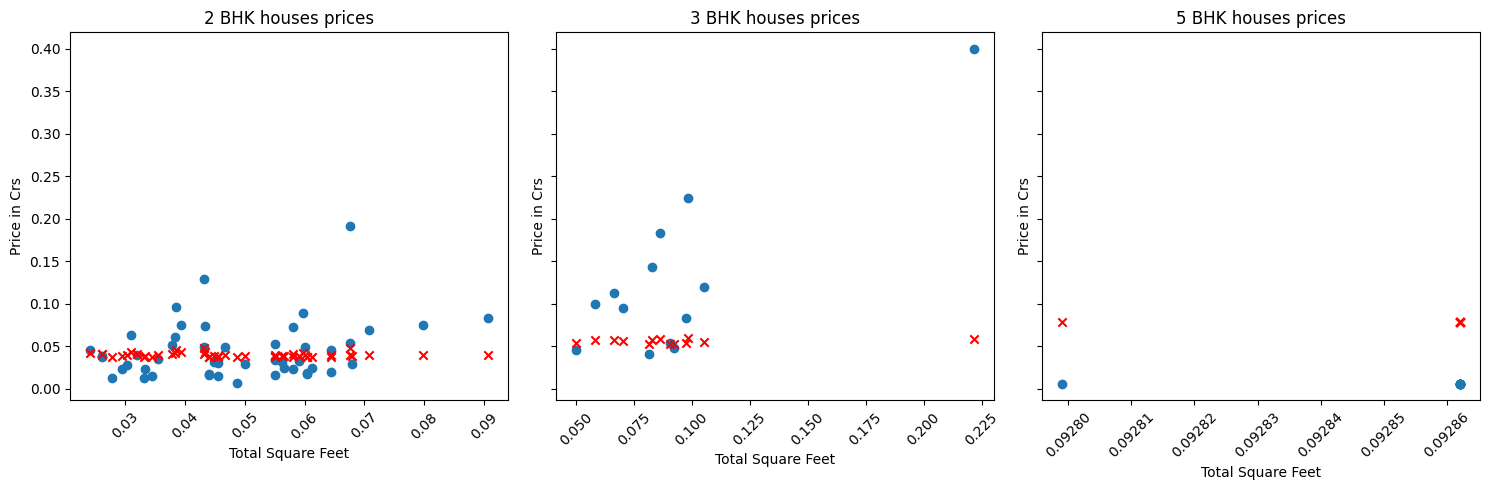

In [431]:
attribute_name, x_axis, y_axis = 'BHK', 'Total sqft', 'price'

bhk_uniques = x_test[attribute_name].unique()
bhk_uniques.sort()
bhk_uniques = bhk_uniques[1:4]

fig, axes = plt.subplots(nrows=1, ncols=len(bhk_uniques), figsize=(15, 5), sharey=True)

for i, u_bhk in enumerate(bhk_uniques):
    indexes = x_test[x_test[attribute_name] == u_bhk].index
    axes[i].scatter(x_test[x_test.index.isin(indexes)][x_axis], y_test[x_test.index.isin(indexes)][y_axis])
    axes[i].scatter(x_test[x_test.index.isin(indexes)][x_axis], y_predictions[x_test.index.isin(indexes)][y_axis], color='red', marker='x')
    axes[i].set_title(f"{u_bhk} BHK houses prices")
    axes[i].set_xlabel("Total Square Feet")
    axes[i].set_ylabel("Price in Crs")

    axes[i].tick_params(axis = 'x', rotation = 45)

plt.tight_layout()
plt.show()